In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/sample_data/who_dataset_fixed.csv")

feature_names = [
    'Infant_deaths', 'Under_five_deaths', 'Adult_mortality',
    'Alcohol_consumption', 'Hepatitis_B', 'Measles',
    'BMI', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
    'Population_mln', 'Thinness_ten_nineteen_years',
    'Thinness_five_nine_years', 'Schooling'
]
target = 'Life_expectancy'

X = df[feature_names].copy()
y = df[target].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_centered = y - y.mean()


In [ ]:

with pm.Model() as linear_model_named:
    X_data = pm.MutableData("X", X_scaled)
    y_data = pm.MutableData("y", y_centered)
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    betas = [pm.Normal(name, mu=0, sigma=1) for name in feature_names]
    beta_stack = pm.math.stack(betas)
    mu = alpha + pm.math.dot(X_data, beta_stack)
    sigma = pm.HalfNormal("sigma", sigma=10)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)
    trace_named = pm.sample(2000, tune=1000, target_accept=0.8, return_inferencedata=True)

/usr/local/lib/python3.11/dist-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

In [ ]:
summary=az.summary(trace_named, round_to=5)

In [ ]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Adult_mortality,-5.59587,0.06984,-5.72064,-5.45690,0.00111,0.00116,3988.69841,2536.75844,1.00062
Alcohol_consumption,0.35610,0.03558,0.28622,0.41867,0.00050,0.00058,5033.59219,3077.58084,1.00033
BMI,-0.36154,0.04008,-0.44051,-0.28902,0.00055,0.00067,5219.52891,2935.97912,0.99970
Diphtheria,0.06577,0.05150,-0.02696,0.16689,0.00081,0.00082,4009.96489,2517.32043,1.00044
GDP_per_capita,0.51962,0.03630,0.44858,0.58655,0.00053,0.00054,4727.72347,2682.06913,0.99999
Hepatitis_B,-0.14955,0.04067,-0.22666,-0.07425,0.00064,0.00057,4093.09177,3044.31188,1.00061
Incidents_HIV,0.22595,0.04271,0.14814,0.31035,0.00065,0.00069,4293.64865,2896.84375,0.99996
Infant_deaths,-1.44442,0.16807,-1.77813,-1.14578,0.00291,0.00259,3338.29717,2841.74575,1.00219
Measles,0.02417,0.03215,-0.03434,0.08494,0.00041,0.00061,6324.61632,2976.68335,1.00194
Population_mln,-0.02399,0.02778,-0.07533,0.02968,0.00038,0.00052,5222.44478,2449.62914,0.99999


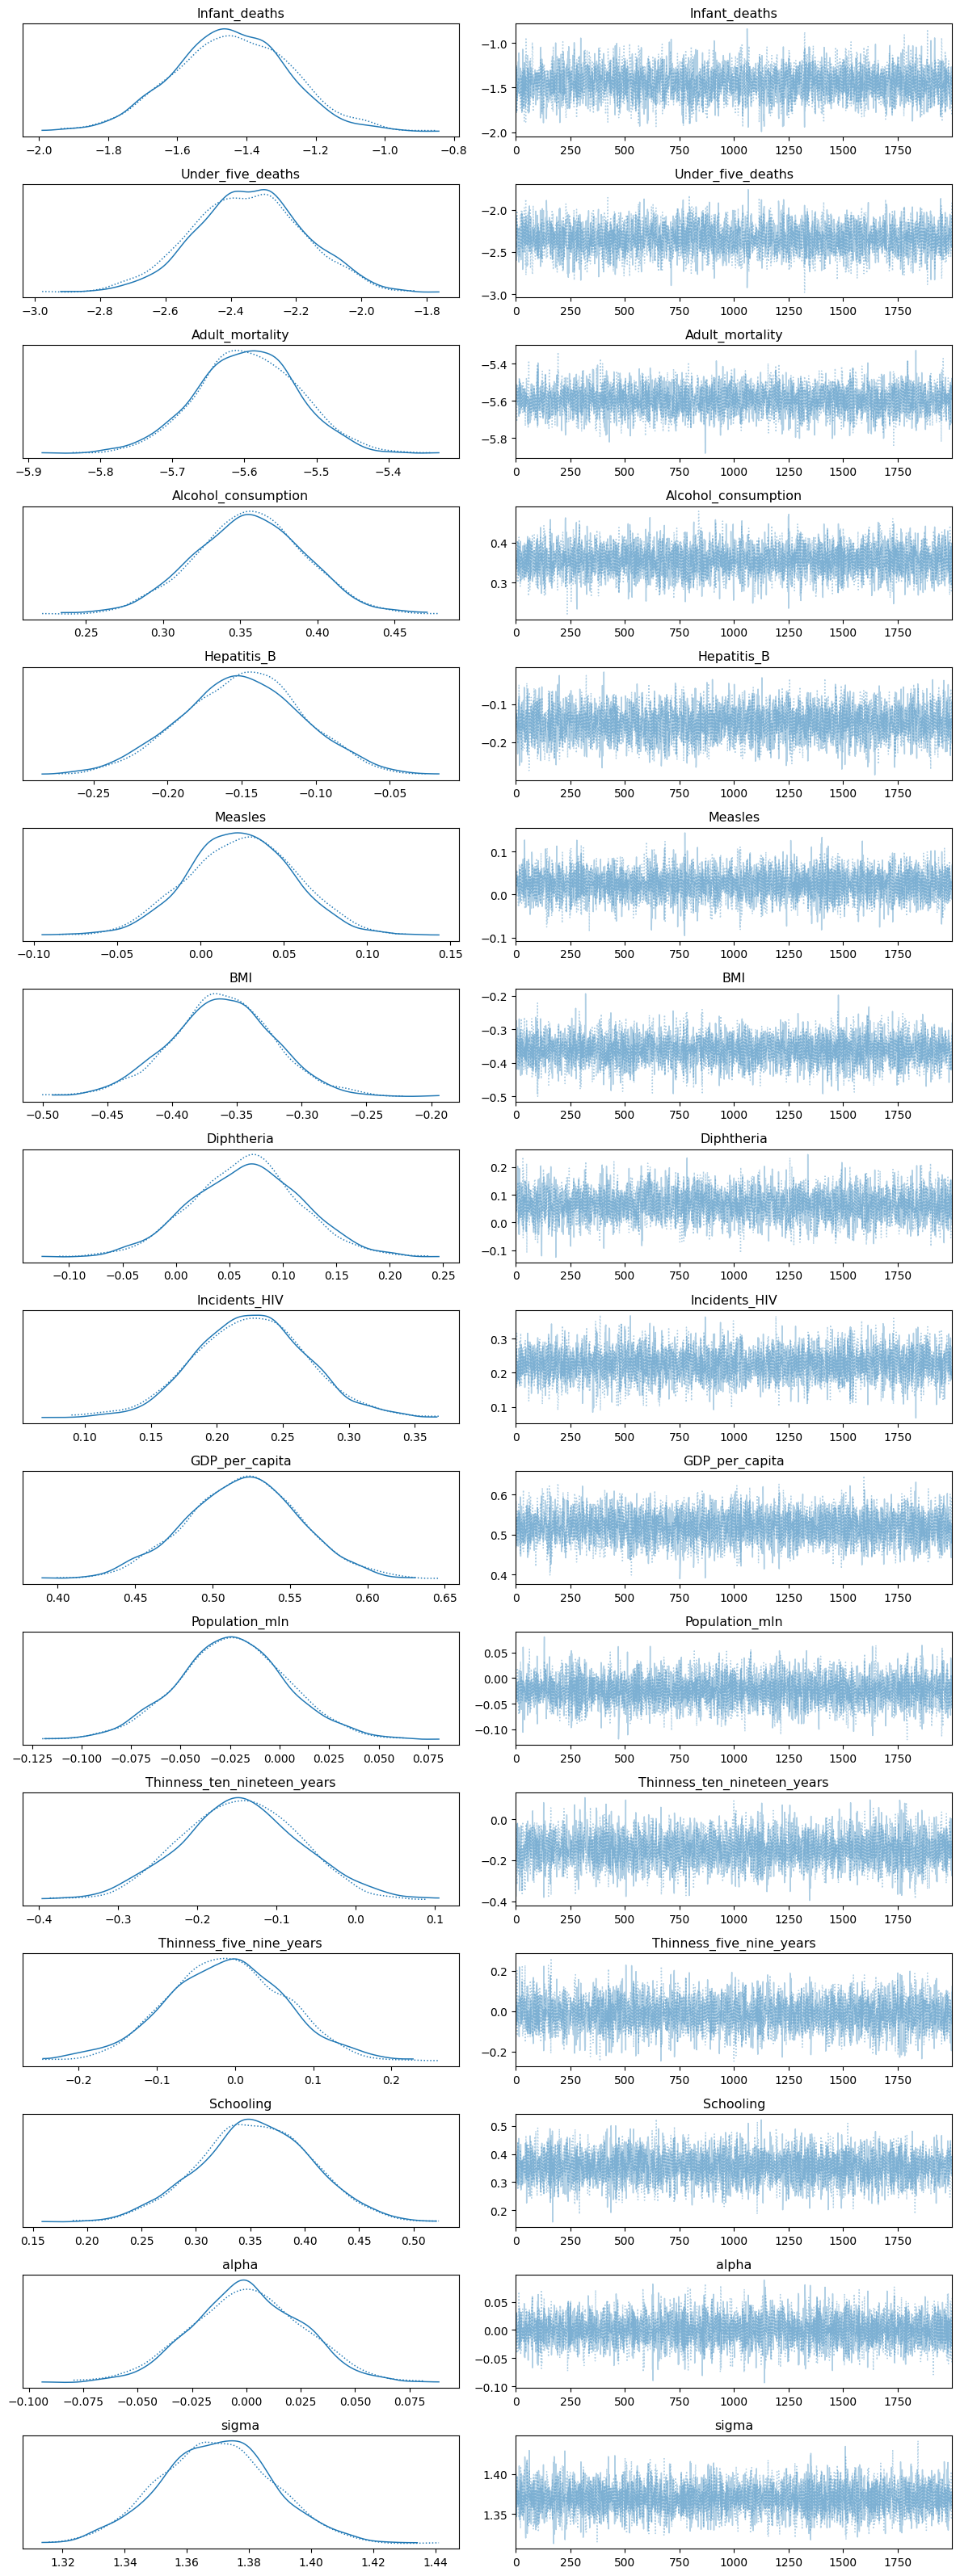

In [ ]:
az.plot_trace(trace_named, var_names=feature_names+["alpha", "sigma"])
plt.tight_layout()
plt.show()

In [ ]:
# Posterior predictive
with linear_model_named:
    posterior_pred = pm.sample_posterior_predictive(trace_named, var_names=["y_obs"])

y_pred_samples = posterior_pred.posterior_predictive["y_obs"].values + y.mean()
if y_pred_samples.ndim == 3:
    y_pred_samples = y_pred_samples.reshape(-1, y_pred_samples.shape[-1])
y_pred_mean = y_pred_samples.mean(axis=0)
lower = np.percentile(y_pred_samples, 3, axis=0)
upper = np.percentile(y_pred_samples, 97, axis=0)


#frequentist
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Frequentist OLS Model
ols_model = LinearRegression()
ols_model.fit(X_scaled, y)
y_pred_ols = ols_model.predict(X_scaled)

Output()

In [ ]:
rmse_bayesian = np.sqrt(mean_squared_error(y, y_pred_mean))
mae_bayesian = mean_absolute_error(y, y_pred_mean)
rmse_ols = np.sqrt(mean_squared_error(y, y_pred_ols))
mae_ols = mean_absolute_error(y, y_pred_ols)

print("\nModel Comparison:")
print(f"Bayesian RMSE: {rmse_bayesian:.3f}, MAE: {mae_bayesian:.3f}")
print(f"OLS RMSE: {rmse_ols:.3f}, MAE: {mae_ols:.3f}")


Model Comparison:
Bayesian RMSE: 1.366, MAE: 1.088
OLS RMSE: 1.365, MAE: 1.087


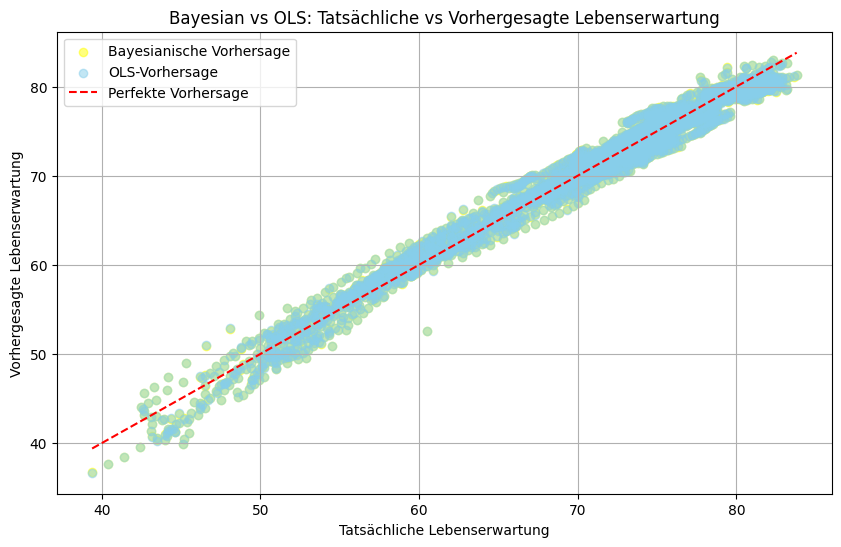

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_mean, alpha=0.5, color='yellow', label='Bayesianische Vorhersage')
plt.scatter(y, y_pred_ols, alpha=0.5, color='skyblue', label='OLS-Vorhersage')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfekte Vorhersage")
plt.xlabel("Tatsächliche Lebenserwartung")
plt.ylabel("Vorhergesagte Lebenserwartung")
plt.title("Bayesian vs OLS: Tatsächliche vs Vorhergesagte Lebenserwartung")
plt.legend()
plt.grid(True)
plt.savefig('bayesian_vs_ols.png')
plt.show()

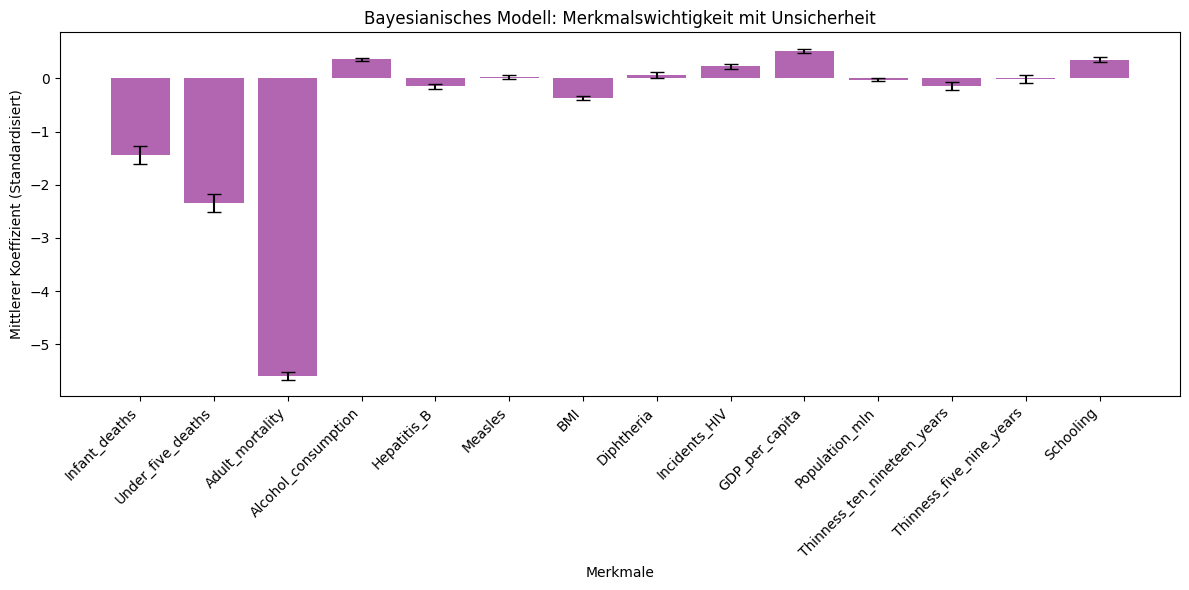

In [ ]:
beta_means = summary.loc[feature_names, 'mean']
beta_sd = summary.loc[feature_names, 'sd']
plt.figure(figsize=(12, 6))
plt.bar(feature_names, beta_means, yerr=beta_sd, capsize=5, color='purple', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Merkmale")
plt.ylabel("Mittlerer Koeffizient (Standardisiert)")
plt.title("Bayesianisches Modell: Merkmalswichtigkeit mit Unsicherheit")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

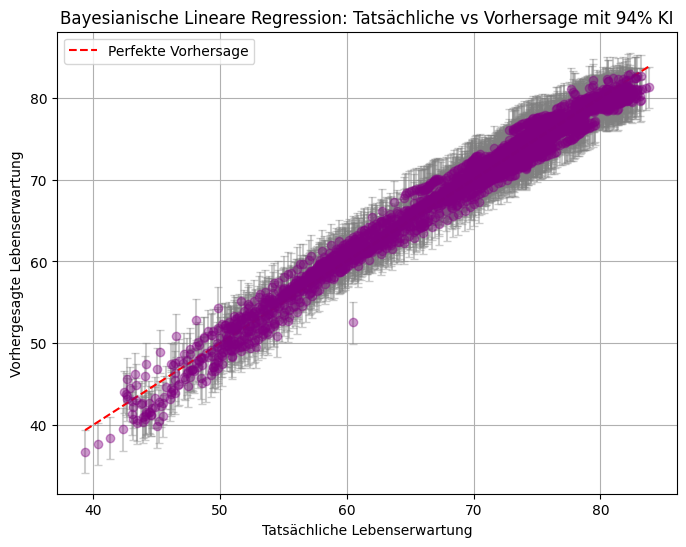

In [ ]:
lower_bound = np.percentile(y_pred_samples, 3, axis=0)
upper_bound = np.percentile(y_pred_samples, 97, axis=0)
plt.figure(figsize=(8, 6))
plt.errorbar(y, y_pred_mean,
             yerr=[y_pred_mean - lower, upper - y_pred_mean],
             fmt='o', alpha=0.4, color='purple', ecolor='gray', capsize=3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfekte Vorhersage")
plt.xlabel("Tatsächliche Lebenserwartung")
plt.ylabel("Vorhergesagte Lebenserwartung")
plt.title("Bayesianische Lineare Regression: Tatsächliche vs Vorhersage mit 94% KI")
plt.legend()
plt.grid(True)
plt.savefig('credible_intervals.png')
plt.show()


array([[<Axes: title={'center': 'Infant_deaths'}>,
        <Axes: title={'center': 'Under_five_deaths'}>,
        <Axes: title={'center': 'Adult_mortality'}>,
        <Axes: title={'center': 'Alcohol_consumption'}>],
       [<Axes: title={'center': 'Hepatitis_B'}>,
        <Axes: title={'center': 'Measles'}>,
        <Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'Diphtheria'}>],
       [<Axes: title={'center': 'Incidents_HIV'}>,
        <Axes: title={'center': 'GDP_per_capita'}>,
        <Axes: title={'center': 'Population_mln'}>,
        <Axes: title={'center': 'Thinness_ten_nineteen_years'}>],
       [<Axes: title={'center': 'Thinness_five_nine_years'}>,
        <Axes: title={'center': 'Schooling'}>, <Axes: >, <Axes: >]],
      dtype=object)

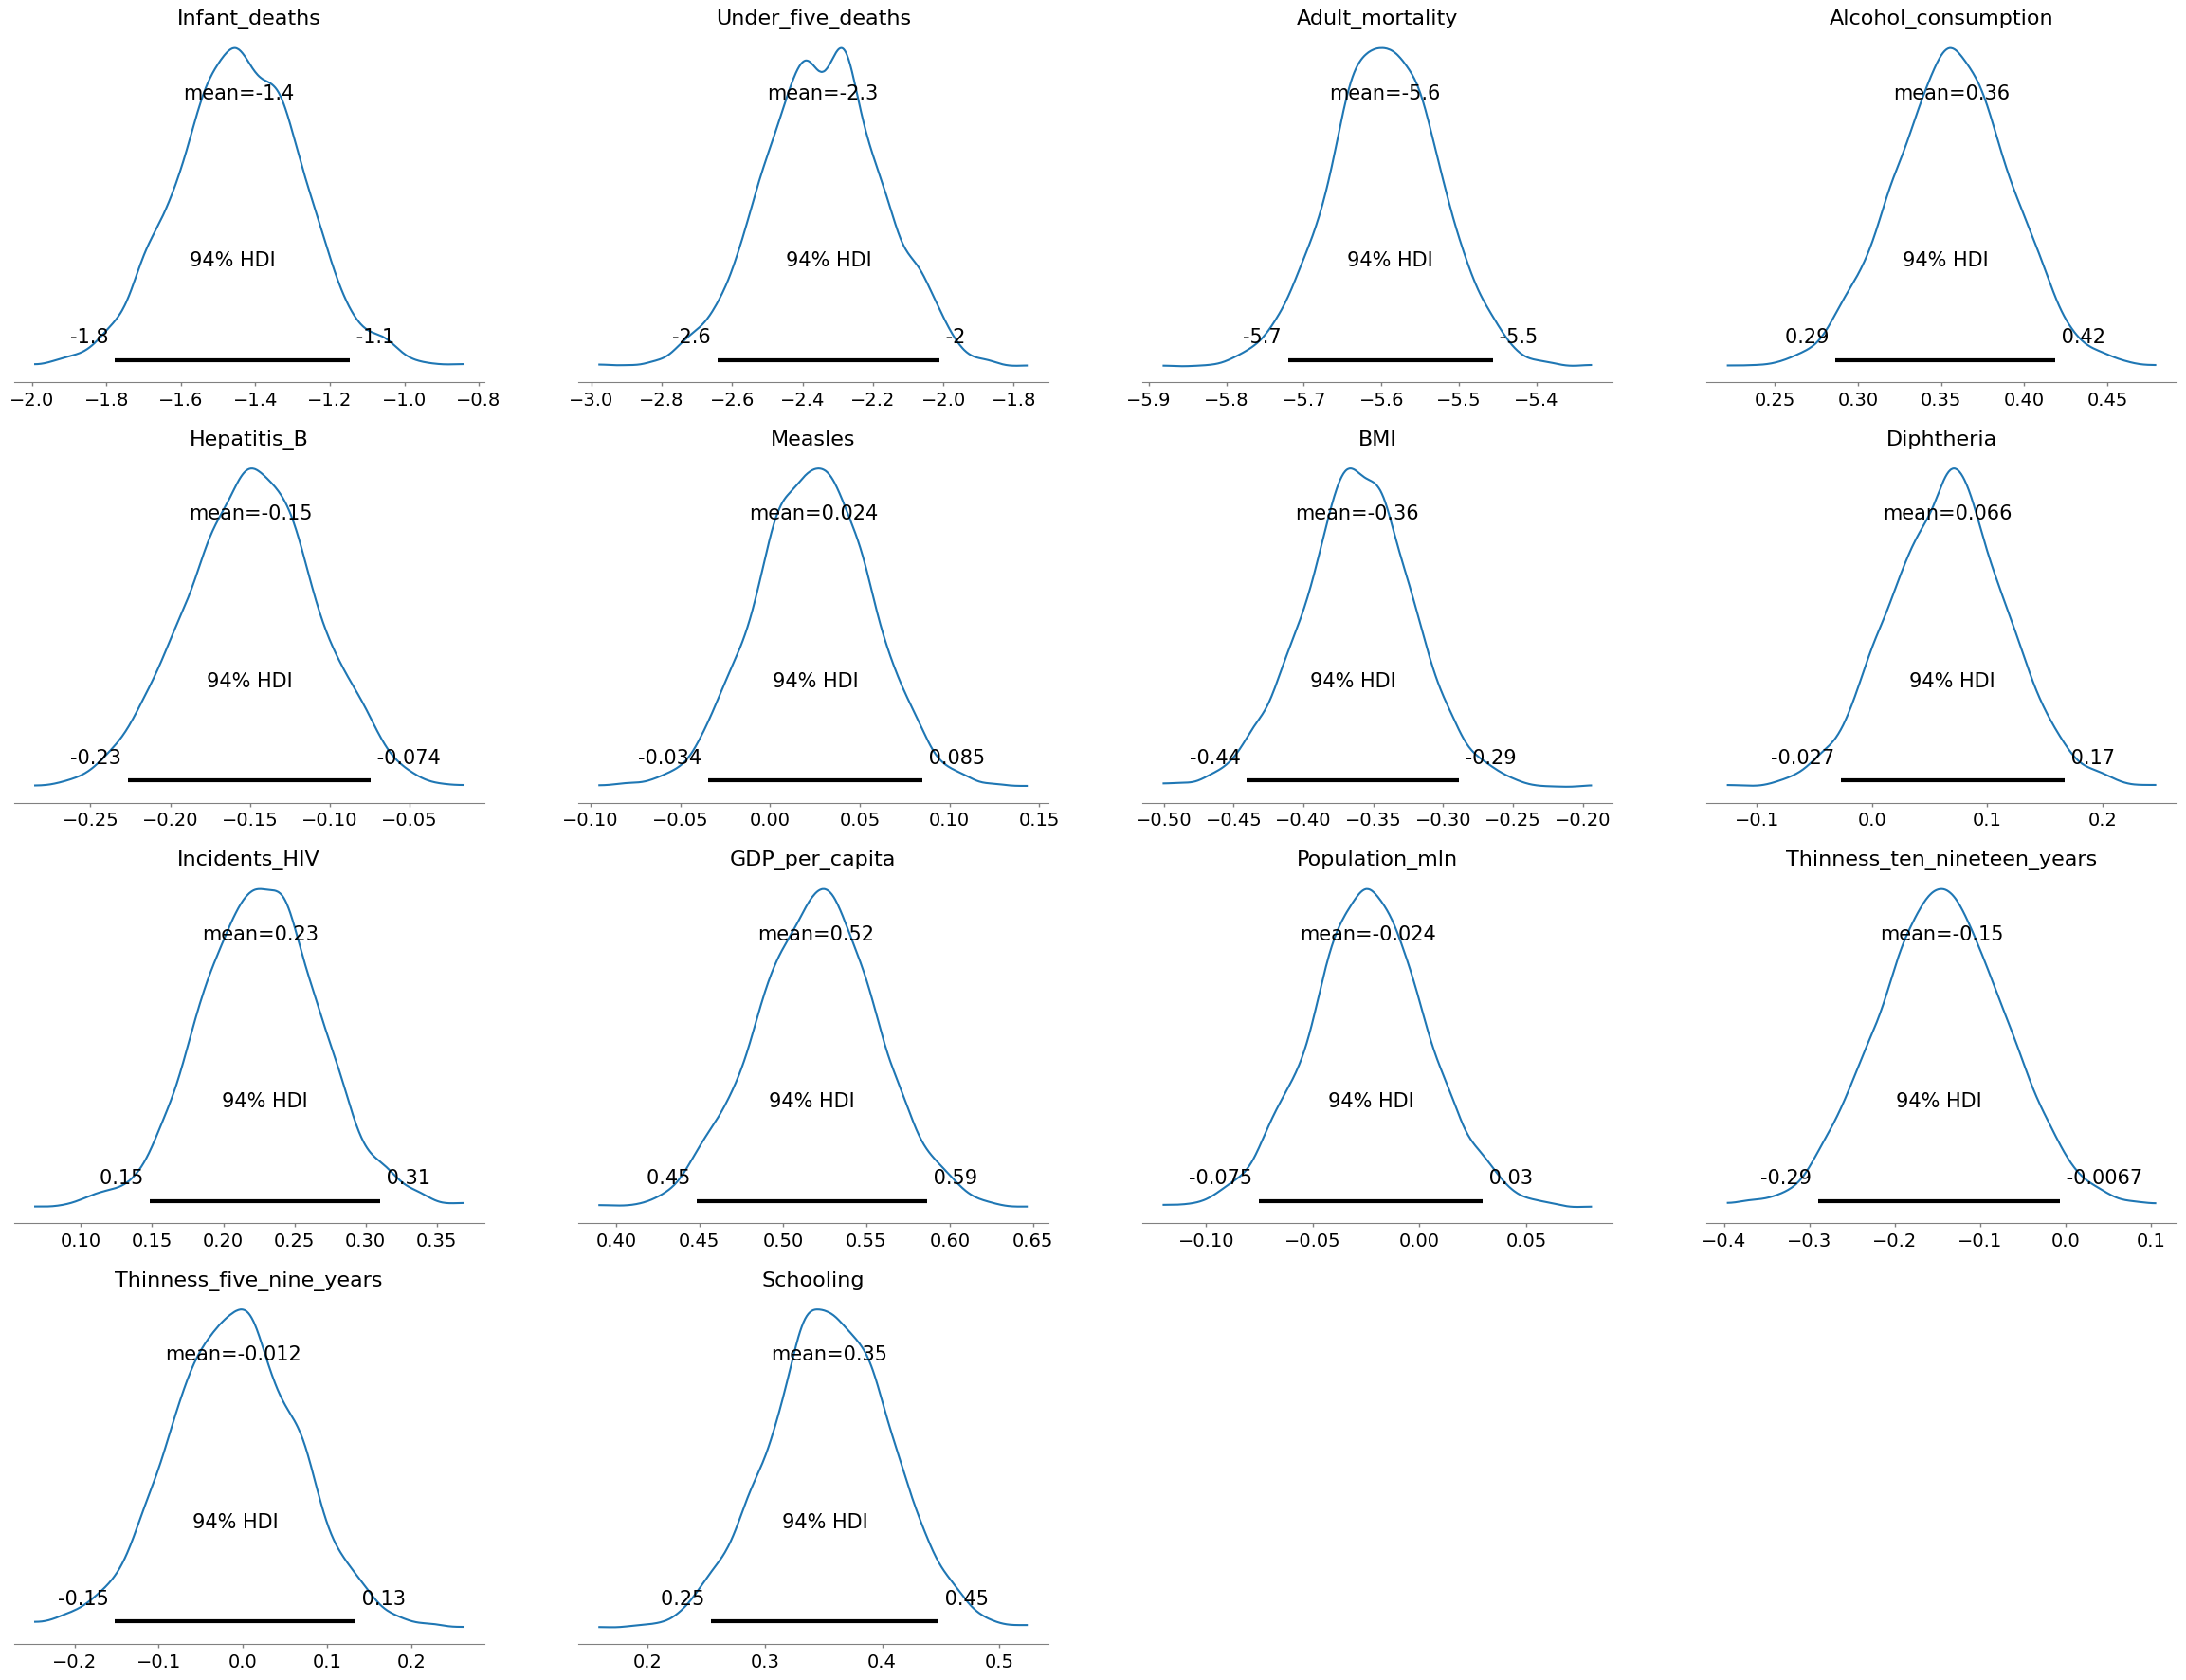

In [ ]:
az.plot_posterior(trace_named, var_names=feature_names)


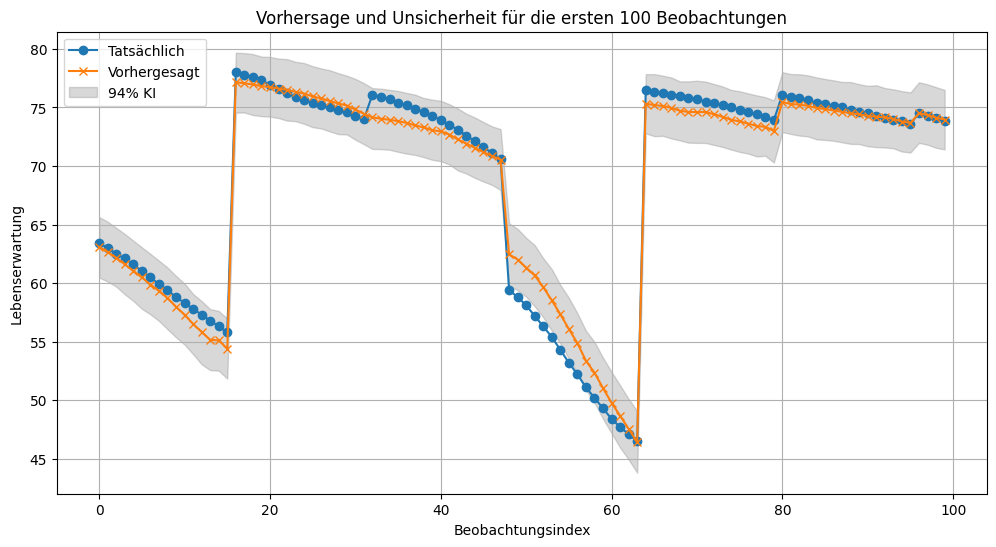

In [ ]:
lower = np.percentile(y_pred_samples, 3, axis=0)
upper = np.percentile(y_pred_samples, 97, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(y[:100], label="Tatsächlich", marker="o")
plt.plot(y_pred_mean[:100], label="Vorhergesagt", marker="x")
plt.fill_between(np.arange(100), lower[:100], upper[:100], alpha=0.3, color="gray", label="94% KI")
plt.title("Vorhersage und Unsicherheit für die ersten 100 Beobachtungen")
plt.ylabel("Lebenserwartung")
plt.xlabel("Beobachtungsindex")
plt.legend()
plt.grid(True)
plt.savefig('first_100_predictions.png')
plt.show()


In [ ]:
countries_of_interest = ["Germany", "Turkiye","United States","United Kingdom"]
df_filtered = df[df["Country"].isin(countries_of_interest)].reset_index(drop=True)

y_filtered = df_filtered["Life_expectancy"].values
y_pred_mean_filtered = y_pred_mean[df_filtered.index]
lower_filtered = lower[df_filtered.index]
upper_filtered = upper[df_filtered.index]
countries = df_filtered["Country"].values

<ipython-input-42-91febbdd3856>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_violin_long, x="Beobachtung", y="Prognostizierte Lebenserwartung", inner="quartile", palette="muted")


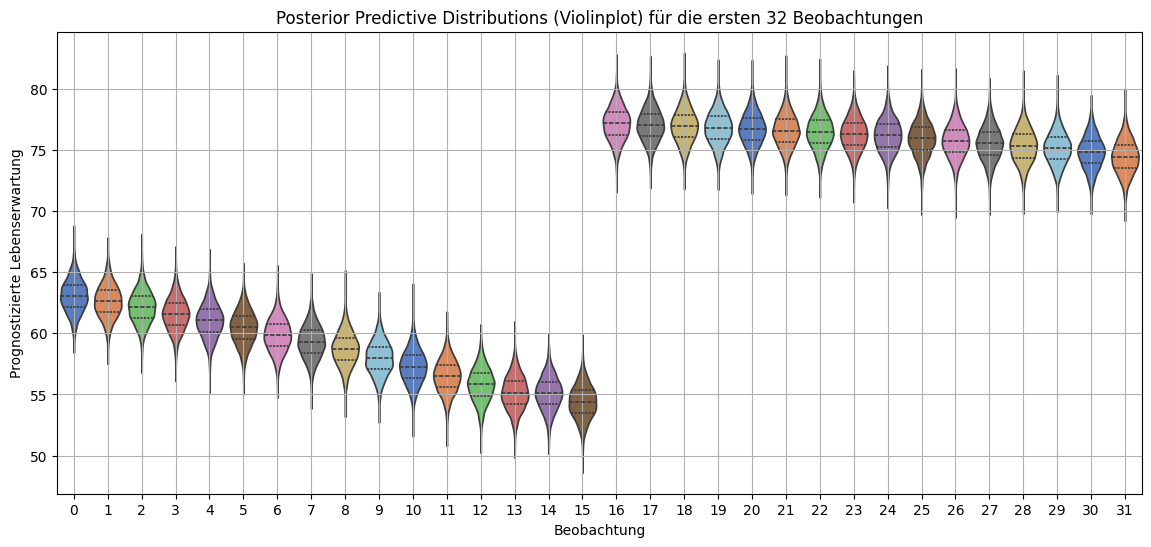

In [ ]:
import seaborn as sns

# Erste 32 Beobachtungen
n_samples_show = 32
subset_samples = y_pred_samples[:, :n_samples_show]

# Daten in Long-Format für Violinplot umwandeln
df_violin = pd.DataFrame(subset_samples)
df_violin_long = df_violin.melt(var_name="Beobachtung", value_name="Prognostizierte Lebenserwartung")

plt.figure(figsize=(14,6))
sns.violinplot(data=df_violin_long, x="Beobachtung", y="Prognostizierte Lebenserwartung", inner="quartile", palette="muted")
plt.title("Posterior Predictive Distributions (Violinplot) für die ersten 32 Beobachtungen")
plt.grid(True)
plt.show()

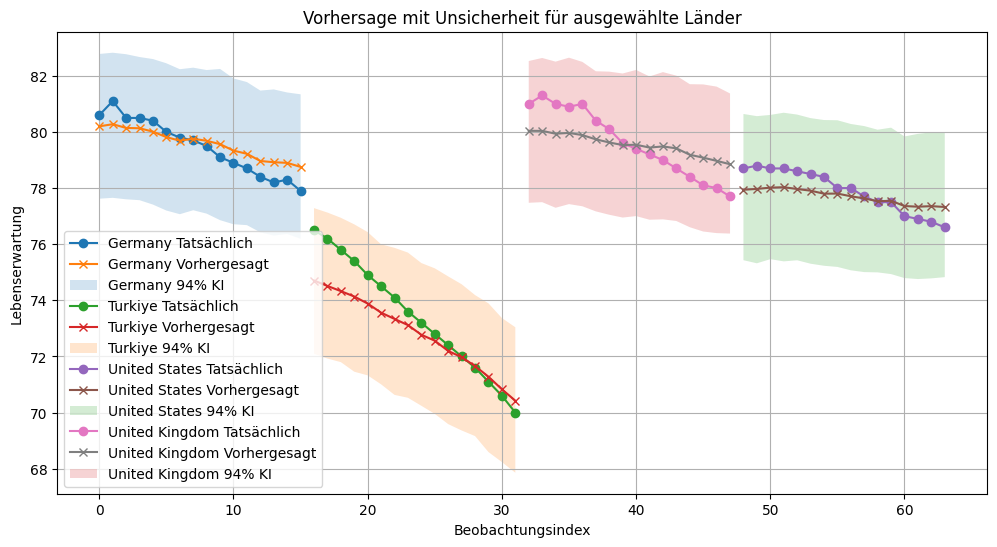

In [ ]:
countries_of_interest = ["Germany", "Turkiye", "United States", "United Kingdom"]
df_filtered = df[df["Country"].isin(countries_of_interest)].copy()
y_filtered = df_filtered["Life_expectancy"].values
original_indices = df_filtered.index
y_pred_mean_filtered = y_pred_mean[original_indices]
lower_filtered = lower[original_indices]
upper_filtered = upper[original_indices]
countries = df_filtered["Country"].values

plt.figure(figsize=(12, 6))
for i, country in enumerate(countries_of_interest):
    indices = np.where(countries == country)[0]
    plt.plot(indices, y_filtered[indices], 'o-', label=f"{country} Tatsächlich")
    plt.plot(indices, y_pred_mean_filtered[indices], 'x-', label=f"{country} Vorhergesagt")
    plt.fill_between(indices, lower_filtered[indices], upper_filtered[indices], alpha=0.2, label=f"{country} 94% KI")
plt.title("Vorhersage mit Unsicherheit für ausgewählte Länder")
plt.xlabel("Beobachtungsindex")
plt.ylabel("Lebenserwartung")
plt.legend()
plt.grid(True)
plt.savefig('countries_prediction.png')
plt.show()

In [ ]:
countries_of_interest = ["Germany", "Turkiye", "United States", "United Kingdom"]
df_filtered = df[df["Country"].isin(countries_of_interest)].copy()
y_filtered = df_filtered["Life_expectancy"].values
original_indices = df_filtered.index
y_pred_mean_filtered = y_pred_mean[original_indices]
lower_filtered = lower[original_indices]
upper_filtered = upper[original_indices]
countries = df_filtered["Country"].values

plt.figure(figsize=(12, 6))
for i, country in enumerate(countries_of_interest):
    indices = np.where(countries == country)[0]
    plt.plot(indices, y_filtered[indices], 'o-', label=f"{country} Actual")
    plt.plot(indices, y_pred_mean_filtered[indices], 'x-', label=f"{country} Predicted")
    plt.fill_between(indices, lower_filtered[indices], upper_filtered[indices], alpha=0.2, label=f"{country} 94% CI")
plt.title("Prediction with Uncertainty for Selected Countries")
plt.xlabel("Observation Index")
plt.ylabel("Life Expectancy")
plt.legend()
plt.grid(True)
plt.show()

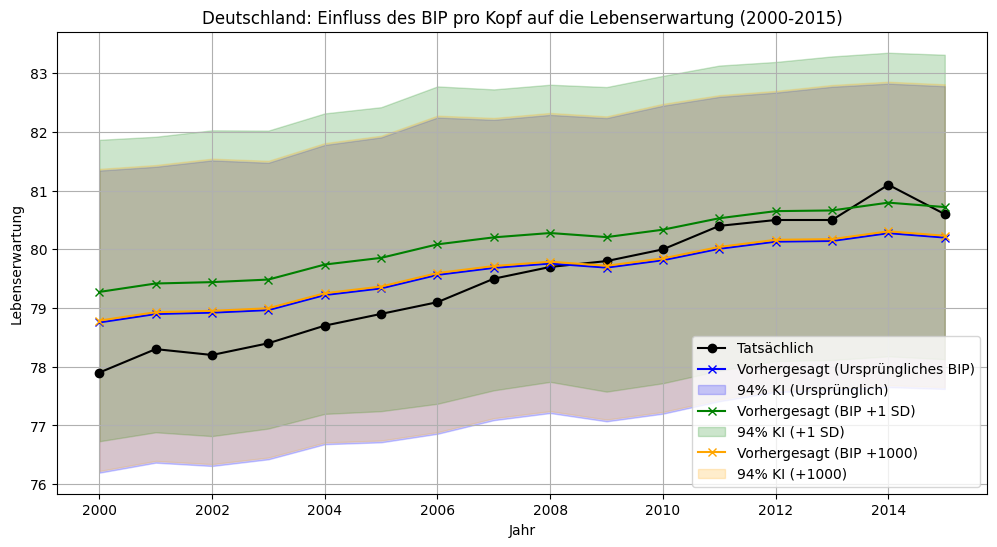


Germany GDP Simulation Results (2000-2015):

Year: 2015
Actual Life Expectancy: 80.60
Predicted (Original GDP): 80.20 (94% CI: [77.62, 82.78])
Predicted (GDP +1 SD): 80.72 (94% CI: [78.13, 83.32])
Predicted (GDP +1000): 80.23 (94% CI: [77.65, 82.81])

Year: 2014
Actual Life Expectancy: 81.10
Predicted (Original GDP): 80.28 (94% CI: [77.65, 82.82])
Predicted (GDP +1 SD): 80.80 (94% CI: [78.18, 83.35])
Predicted (GDP +1000): 80.31 (94% CI: [77.69, 82.86])

Year: 2013
Actual Life Expectancy: 80.50
Predicted (Original GDP): 80.14 (94% CI: [77.60, 82.77])
Predicted (GDP +1 SD): 80.66 (94% CI: [78.11, 83.29])
Predicted (GDP +1000): 80.17 (94% CI: [77.63, 82.80])

Year: 2012
Actual Life Expectancy: 80.50
Predicted (Original GDP): 80.13 (94% CI: [77.57, 82.67])
Predicted (GDP +1 SD): 80.65 (94% CI: [78.10, 83.19])
Predicted (GDP +1000): 80.16 (94% CI: [77.60, 82.70])

Year: 2011
Actual Life Expectancy: 80.40
Predicted (Original GDP): 80.01 (94% CI: [77.41, 82.60])
Predicted (GDP +1 SD): 80.53

In [ ]:
germany_data = df[df["Country"] == "Germany"].copy()
germany_indices = germany_data.index
germany_years = germany_data["Year"].values
germany_actual = germany_data["Life_expectancy"].values

germany_pred_samples = y_pred_samples[:, germany_indices]
germany_pred_mean = y_pred_mean[germany_indices]
germany_pred_lower = lower[germany_indices]  # 94% CI
germany_pred_upper = upper[germany_indices]  # 94% CI

gdp_beta = summary.loc["GDP_per_capita", "mean"]
gdp_beta_sd = summary.loc["GDP_per_capita", "sd"]
gdp_idx = feature_names.index("GDP_per_capita")
gdp_original = germany_data["GDP_per_capita"].values
gdp_scaled = X_scaled[germany_indices, gdp_idx]


gdp_scaled_plus_1sd = gdp_scaled + 1.0

gdp_original_plus_1000 = gdp_original + 1000

gdp_scaled_plus_1000 = scaler.transform(germany_data[feature_names].copy())
gdp_scaled_plus_1000[:, gdp_idx] = (gdp_original_plus_1000 - scaler.mean_[gdp_idx]) / scaler.scale_[gdp_idx]
gdp_scaled_plus_1000 = gdp_scaled_plus_1000[:, gdp_idx]

delta_gdp_1sd = gdp_scaled_plus_1sd - gdp_scaled
germany_pred_mean_1sd = germany_pred_mean + delta_gdp_1sd * gdp_beta

germany_pred_samples_1sd = germany_pred_samples + delta_gdp_1sd[None, :] * np.random.normal(gdp_beta, gdp_beta_sd, size=(germany_pred_samples.shape[0], 1))
germany_pred_lower_1sd = np.percentile(germany_pred_samples_1sd, 3, axis=0)
germany_pred_upper_1sd = np.percentile(germany_pred_samples_1sd, 97, axis=0)

germany_pred_mean_1000 = germany_pred_mean + delta_gdp_1000 * gdp_beta
germany_pred_samples_1000 = germany_pred_samples + delta_gdp_1000[None, :] * np.random.normal(gdp_beta, gdp_beta_sd, size=(germany_pred_samples.shape[0], 1))
germany_pred_lower_1000 = np.percentile(germany_pred_samples_1000, 3, axis=0)
germany_pred_upper_1000 = np.percentile(germany_pred_samples_1000, 97, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(germany_years, germany_actual, 'o-', label="Tatsächlich", color='black')
plt.plot(germany_years, germany_pred_mean, 'x-', label="Vorhergesagt (Ursprüngliches BIP)", color='blue')
plt.fill_between(germany_years, germany_pred_lower, germany_pred_upper, alpha=0.2, color='blue', label="94% KI (Ursprünglich)")
plt.plot(germany_years, germany_pred_mean_1sd, 'x-', label="Vorhergesagt (BIP +1 SD)", color='green')
plt.fill_between(germany_years, germany_pred_lower_1sd, germany_pred_upper_1sd, alpha=0.2, color='green', label="94% KI (+1 SD)")
plt.plot(germany_years, germany_pred_mean_1000, 'x-', label="Vorhergesagt (BIP +1000)", color='orange')
plt.fill_between(germany_years, germany_pred_lower_1000, germany_pred_upper_1000, alpha=0.2, color='orange', label="94% KI (+1000)")
plt.xlabel("Jahr")
plt.ylabel("Lebenserwartung")
plt.title("Deutschland: Einfluss des BIP pro Kopf auf die Lebenserwartung (2000-2015)")
plt.legend()
plt.grid(True)
plt.savefig('germany_gdp_simulation.png')
plt.show()

print("\nGermany GDP Simulation Results (2000-2015):")
for year, actual, orig_mean, orig_lower, orig_upper, mean_1sd, lower_1sd, upper_1sd, mean_1000, lower_1000, upper_1000 in zip(
    germany_years, germany_actual, germany_pred_mean, germany_pred_lower, germany_pred_upper,
    germany_pred_mean_1sd, germany_pred_lower_1sd, germany_pred_upper_1sd,
    germany_pred_mean_1000, germany_pred_lower_1000, germany_pred_upper_1000
):
    print(f"\nYear: {year}")
    print(f"Actual Life Expectancy: {actual:.2f}")
    print(f"Predicted (Original GDP): {orig_mean:.2f} (94% CI: [{orig_lower:.2f}, {orig_upper:.2f}])")
    print(f"Predicted (GDP +1 SD): {mean_1sd:.2f} (94% CI: [{lower_1sd:.2f}, {upper_1sd:.2f}])")
    print(f"Predicted (GDP +1000): {mean_1000:.2f} (94% CI: [{lower_1000:.2f}, {upper_1000:.2f}])")

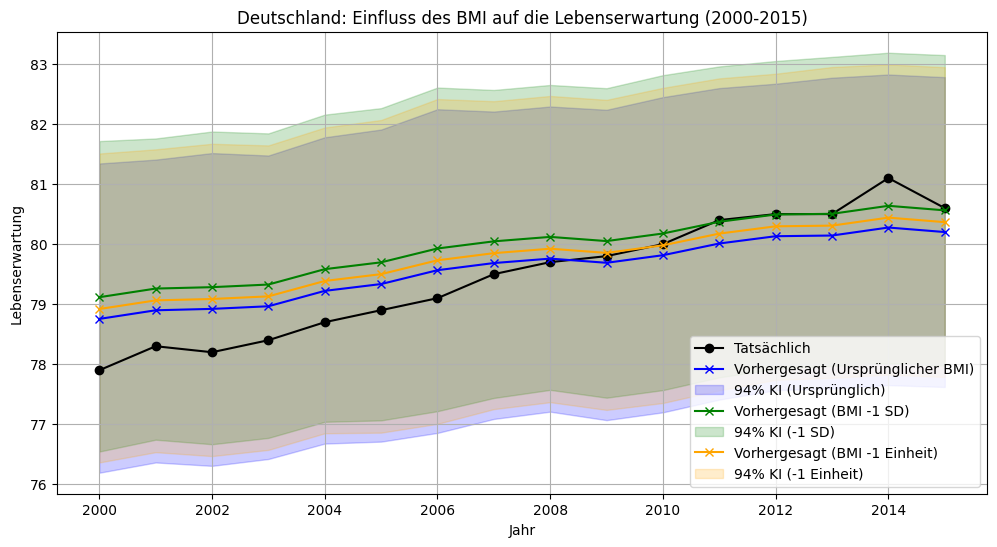


Germany BMI Simulation Results (2000-2015):

Year: 2015
Actual Life Expectancy: 80.60
Predicted (Original BMI): 80.20 (94% CI: [77.62, 82.78])
Predicted (BMI -1 SD): 80.56 (94% CI: [77.98, 83.15])
Predicted (BMI -1 Unit): 80.37 (94% CI: [77.79, 82.95])

Year: 2014
Actual Life Expectancy: 81.10
Predicted (Original BMI): 80.28 (94% CI: [77.65, 82.82])
Predicted (BMI -1 SD): 80.64 (94% CI: [78.02, 83.19])
Predicted (BMI -1 Unit): 80.44 (94% CI: [77.83, 82.99])

Year: 2013
Actual Life Expectancy: 80.50
Predicted (Original BMI): 80.14 (94% CI: [77.60, 82.77])
Predicted (BMI -1 SD): 80.50 (94% CI: [77.97, 83.12])
Predicted (BMI -1 Unit): 80.31 (94% CI: [77.77, 82.95])

Year: 2012
Actual Life Expectancy: 80.50
Predicted (Original BMI): 80.13 (94% CI: [77.57, 82.67])
Predicted (BMI -1 SD): 80.49 (94% CI: [77.93, 83.05])
Predicted (BMI -1 Unit): 80.30 (94% CI: [77.74, 82.84])

Year: 2011
Actual Life Expectancy: 80.40
Predicted (Original BMI): 80.01 (94% CI: [77.41, 82.60])
Predicted (BMI -1 SD

In [ ]:
bmi_idx = feature_names.index("BMI")
bmi_beta = summary.loc["BMI", "mean"]
bmi_beta_sd = summary.loc["BMI", "sd"]

bmi_original = germany_data["BMI"].values
bmi_scaled = X_scaled[germany_indices, bmi_idx]

bmi_scaled_minus_1sd = bmi_scaled - 1.0
bmi_original_minus_1 = bmi_original - 1.0
bmi_scaled_minus_1unit = scaler.transform(germany_data[feature_names].copy())
bmi_scaled_minus_1unit[:, bmi_idx] = (bmi_original_minus_1 - scaler.mean_[bmi_idx]) / scaler.scale_[bmi_idx]
bmi_scaled_minus_1unit = bmi_scaled_minus_1unit[:, bmi_idx]

delta_bmi_1sd = bmi_scaled_minus_1sd - bmi_scaled
germany_pred_mean_bmi_1sd = germany_pred_mean + delta_bmi_1sd * bmi_beta
germany_pred_samples_bmi_1sd = germany_pred_samples + delta_bmi_1sd[None, :] * np.random.normal(bmi_beta, bmi_beta_sd, size=(germany_pred_samples.shape[0], 1))
germany_pred_lower_bmi_1sd = np.percentile(germany_pred_samples_bmi_1sd, 3, axis=0)
germany_pred_upper_bmi_1sd = np.percentile(germany_pred_samples_bmi_1sd, 97, axis=0)

delta_bmi_1unit = bmi_scaled_minus_1unit - bmi_scaled
germany_pred_mean_bmi_1unit = germany_pred_mean + delta_bmi_1unit * bmi_beta
germany_pred_samples_bmi_1unit = germany_pred_samples + delta_bmi_1unit[None, :] * np.random.normal(bmi_beta, bmi_beta_sd, size=(germany_pred_samples.shape[0], 1))
germany_pred_lower_bmi_1unit = np.percentile(germany_pred_samples_bmi_1unit, 3, axis=0)
germany_pred_upper_bmi_1unit = np.percentile(germany_pred_samples_bmi_1unit, 97, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(germany_years, germany_actual, 'o-', label="Tatsächlich", color='black')
plt.plot(germany_years, germany_pred_mean, 'x-', label="Vorhergesagt (Ursprünglicher BMI)", color='blue')
plt.fill_between(germany_years, germany_pred_lower, germany_pred_upper, alpha=0.2, color='blue', label="94% KI (Ursprünglich)")
plt.plot(germany_years, germany_pred_mean_bmi_1sd, 'x-', label="Vorhergesagt (BMI -1 SD)", color='green')
plt.fill_between(germany_years, germany_pred_lower_bmi_1sd, germany_pred_upper_bmi_1sd, alpha=0.2, color='green', label="94% KI (-1 SD)")
plt.plot(germany_years, germany_pred_mean_bmi_1unit, 'x-', label="Vorhergesagt (BMI -1 Einheit)", color='orange')
plt.fill_between(germany_years, germany_pred_lower_bmi_1unit, germany_pred_upper_bmi_1unit, alpha=0.2, color='orange', label="94% KI (-1 Einheit)")
plt.xlabel("Jahr")
plt.ylabel("Lebenserwartung")
plt.title("Deutschland: Einfluss des BMI auf die Lebenserwartung (2000-2015)")
plt.legend()
plt.grid(True)
plt.savefig('germany_bmi_simulation.png')
plt.show()

print("\nGermany BMI Simulation Results (2000-2015):")
for year, actual, orig_mean, orig_lower, orig_upper, mean_1sd, lower_1sd, upper_1sd, mean_1unit, lower_1unit, upper_1unit in zip(
    germany_years, germany_actual, germany_pred_mean, germany_pred_lower, germany_pred_upper,
    germany_pred_mean_bmi_1sd, germany_pred_lower_bmi_1sd, germany_pred_upper_bmi_1sd,
    germany_pred_mean_bmi_1unit, germany_pred_lower_bmi_1unit, germany_pred_upper_bmi_1unit
):
    print(f"\nYear: {year}")
    print(f"Actual Life Expectancy: {actual:.2f}")
    print(f"Predicted (Original BMI): {orig_mean:.2f} (94% CI: [{orig_lower:.2f}, {orig_upper:.2f}])")
    print(f"Predicted (BMI -1 SD): {mean_1sd:.2f} (94% CI: [{lower_1sd:.2f}, {upper_1sd:.2f}])")
    print(f"Predicted (BMI -1 Unit): {mean_1unit:.2f} (94% CI: [{lower_1unit:.2f}, {upper_1unit:.2f}])")

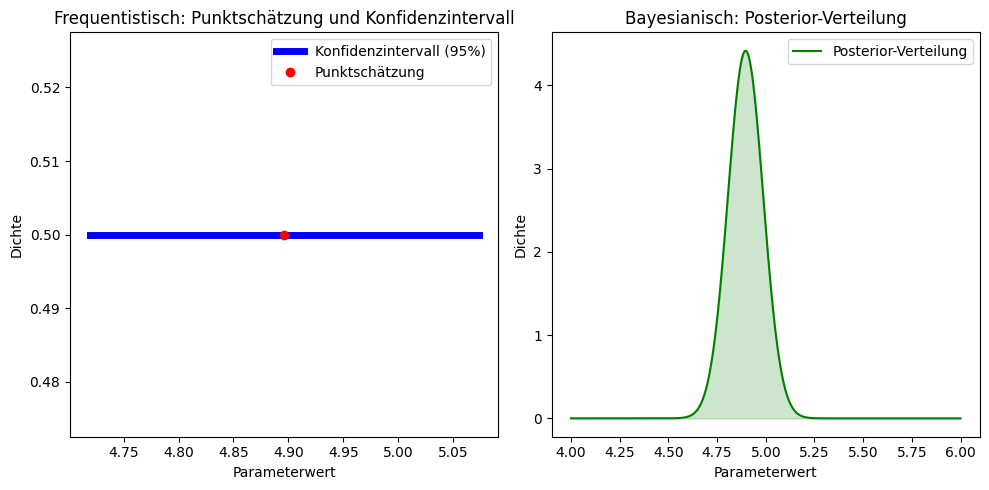

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, beta

# Daten und Parameter
np.random.seed(42)
data = np.random.normal(loc=5, scale=1, size=100)
mean = np.mean(data)
std = np.std(data) / np.sqrt(len(data))  # Standardfehler

# Frequentistisch: Punktschätzung und 95%-Konfidenzintervall
ci_lower = mean - 1.96 * std
ci_upper = mean + 1.96 * std

# Bayesianisch: Posterior-Verteilung (Beispiel: Normalverteilung)
x = np.linspace(4, 6, 1000)
posterior = norm.pdf(x, mean, std)

# Visualisierung
plt.figure(figsize=(10, 5))

# Frequentistisches Konfidenzintervall
plt.subplot(1, 2, 1)
plt.plot([ci_lower, ci_upper], [0.5, 0.5], 'b-', lw=5, label='Konfidenzintervall (95%)')
plt.plot([mean], [0.5], 'ro', label='Punktschätzung')
plt.title('Frequentistisch: Punktschätzung und Konfidenzintervall')
plt.xlabel('Parameterwert')
plt.ylabel('Dichte')
plt.legend()

# Bayesianische Posterior-Verteilung
plt.subplot(1, 2, 2)
plt.plot(x, posterior, 'g-', label='Posterior-Verteilung')
plt.fill_between(x, posterior, alpha=0.2, color='green')
plt.title('Bayesianisch: Posterior-Verteilung')
plt.xlabel('Parameterwert')
plt.ylabel('Dichte')
plt.legend()

plt.tight_layout()
plt.savefig('frequentistisch_vs_bayesianisch.png')
plt.show()

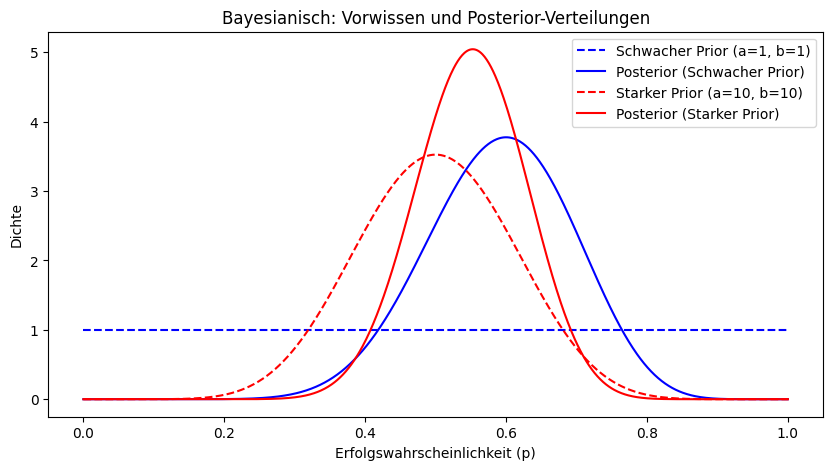

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Parameter
a_prior1, b_prior1 = 1, 1  # Schwacher Prior (uniform)
a_prior2, b_prior2 = 10, 10  # Starker Prior
n_trials = 20
n_heads = 12

# Posterior-Berechnungen
a_post1, b_post1 = a_prior1 + n_heads, b_prior1 + n_trials - n_heads
a_post2, b_post2 = a_prior2 + n_heads, b_prior2 + n_trials - n_heads

# Verteilungen
x = np.linspace(0, 1, 1000)
prior1 = beta.pdf(x, a_prior1, b_prior1)
prior2 = beta.pdf(x, a_prior2, b_prior2)
posterior1 = beta.pdf(x, a_post1, b_post1)
posterior2 = beta.pdf(x, a_post2, b_post2)

# Visualisierung
plt.figure(figsize=(10, 5))

plt.plot(x, prior1, 'b--', label='Schwacher Prior (a=1, b=1)')
plt.plot(x, posterior1, 'b-', label='Posterior (Schwacher Prior)')
plt.plot(x, prior2, 'r--', label='Starker Prior (a=10, b=10)')
plt.plot(x, posterior2, 'r-', label='Posterior (Starker Prior)')
plt.title('Bayesianisch: Vorwissen und Posterior-Verteilungen')
plt.xlabel('Erfolgswahrscheinlichkeit (p)')
plt.ylabel('Dichte')
plt.legend()

plt.savefig('bayesianisch_prior_posterior.png')
plt.show()

Output()

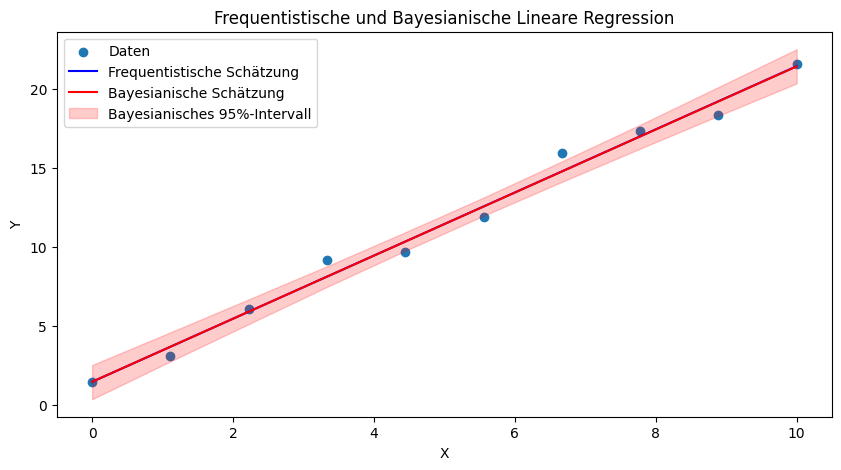

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pymc as pm

# Daten generieren
np.random.seed(42)
x = np.linspace(0, 10, 10)
y = 2 * x + 1 + np.random.normal(0, 1, 10)

# Frequentistische lineare Regression
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Bayesianische lineare Regression (PyMC)
with pm.Model() as bayes_model:
    slope = pm.Normal('slope', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = slope * x + intercept
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
    trace = pm.sample(1000, tune=1000, return_inferencedata=False)

# Visualisierung
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='Daten')
plt.plot(x, y_pred, 'b-', label='Frequentistische Schätzung')

# Bayesianische Schätzung und Unsicherheit
slopes = trace['slope']
intercepts = trace['intercept']
y_bayes_mean = np.mean(slopes) * x + np.mean(intercepts)
y_bayes_samples = np.array([slope * x + intercept for slope, intercept in zip(slopes, intercepts)])
y_bayes_lower = np.percentile(y_bayes_samples, 2.5, axis=0)
y_bayes_upper = np.percentile(y_bayes_samples, 97.5, axis=0)

plt.plot(x, y_bayes_mean, 'r-', label='Bayesianische Schätzung')
plt.fill_between(x, y_bayes_lower, y_bayes_upper, color='red', alpha=0.2, label='Bayesianisches 95%-Intervall')
plt.title('Frequentistische und Bayesianische Lineare Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.savefig('bayesianisch_robustheit.png')
plt.show()

Output()

Output()

Output()

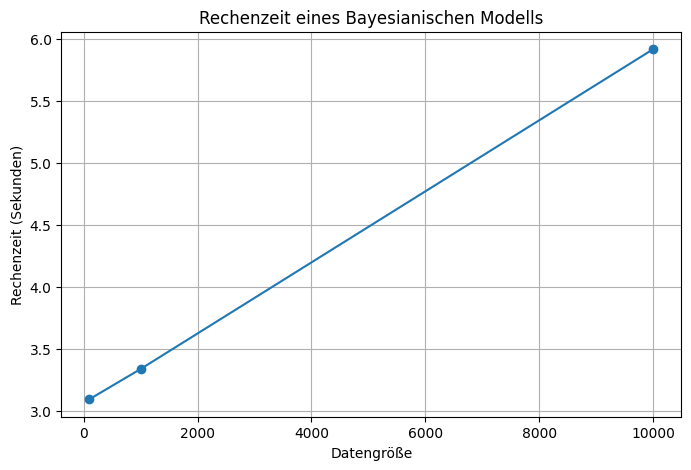

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import time

# Unterschiedliche Datengrößen
sizes = [100, 1000, 10000]
times = []

for n in sizes:
    data = np.random.normal(0, 1, n)
    start_time = time.time()
    with pm.Model():
        mu = pm.Normal('mu', mu=0, sigma=10)
        sigma = pm.HalfNormal('sigma', sigma=1)
        likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=data)
        trace = pm.sample(1000, tune=1000, return_inferencedata=False)
    times.append(time.time() - start_time)

# Visualisierung
plt.figure(figsize=(8, 5))
plt.plot(sizes, times, 'o-')
plt.title('Rechenzeit eines Bayesianischen Modells')
plt.xlabel('Datengröße')
plt.ylabel('Rechenzeit (Sekunden)')
plt.grid(True)
plt.savefig('bayesianisch_rechenzeit.png')
plt.show()